In [1]:
from desc.grid import Grid, LinearGrid
from desc.plotting import plot_surfaces, plot_3d, plot_comparison
from desc.geometry import FourierRZToroidalSurface
from desc.equilibrium import Equilibrium
from desc.continuation import solve_continuation_automatic
from desc.objectives import ParticleTracer
import desc.io
from desc.backend import jnp
import scipy.constants

DESC version 0+untagged.5938.g4e98eb5.dirty,using JAX backend, jax version=0.4.14, jaxlib version=0.4.14, dtype=float64
Using device: CPU, with 1.56 GB available memory


In [2]:
eq = desc.io.load("input.LandremanPaul2021_QA_scaled_output.h5")[-1]
eq._iota = eq.get_profile("iota").to_powerseries(order=eq.L, sym=True)
eq._current = None
# eq.solve()

eq2 = desc.io.load("optimized_input.LandremanPaul2021_QA_scaled_output.h5")
eq2._iota = eq.get_profile("iota").to_powerseries(order=eq.L, sym=True)
eq2._current = None
# eq.solve()

/home/joaobiu/DESC/desc/io/hdf5_io.py:125: RuntimeWarning: Save attribute '_anisotropy' was not loaded.
  warnings.warn(


(<Figure size 1152x960 with 6 Axes>,
 array([<Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.000$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.167$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.333$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.500$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.667$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <Axes: title={'center': '$\\phi \\cdot N_{FP}/2\\pi = 0.833$'}, xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

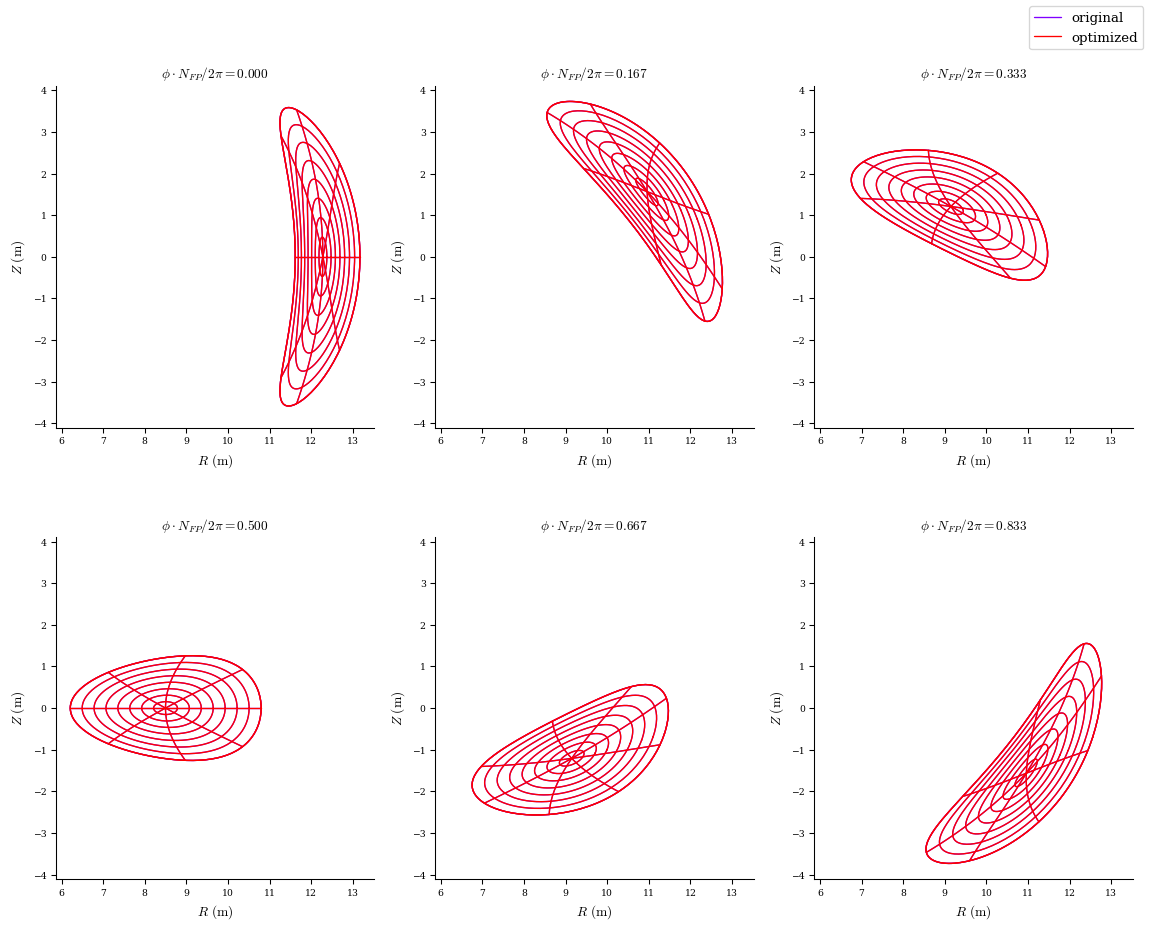

In [3]:
plot_comparison([eq, eq2], labels=["original", "optimized"])

In [4]:
eq = desc.io.load("DESC_ellipse.vacuum.0609.a_fixed_bdry_L_15_M_15_N_15_nfev_300_Mgrid_26_ftol_1e-4.h5")[-1]
eq._iota = eq.get_profile("iota").to_powerseries(order=eq.L, sym=True)
eq._current = None
eq.Psi = eq.Psi*100
# eq.solve()
eq.save("ellipse_higherPsi.h5")

/home/joaobiu/DESC/desc/io/hdf5_io.py:125: RuntimeWarning: Save attribute '_anisotropy' was not loaded.
  warnings.warn(


In [5]:
# Energy and Mass info
Energy_eV = 3.52e6
Proton_Mass = scipy.constants.proton_mass
Proton_Charge = scipy.constants.elementary_charge

Energy_SI = Energy_eV*Proton_Charge

# Particle Info
Mass = 4*Proton_Mass
Charge = 2*Proton_Charge

# Initial State
psi_i = 0.2
zeta_i = 0
theta_i = 0
vpar_i = 0.9*jnp.sqrt(2*Energy_SI/Mass)
ini_cond = [float(psi_i), theta_i, zeta_i, float(vpar_i)]

# Time
tmin = 0
tmax = 1e-2
nt = 1000
time = jnp.linspace(tmin, tmax, nt)

initial_conditions = ini_cond
Mass_Charge_Ratio = Mass/Charge

In [6]:
grid = Grid(jnp.array([jnp.sqrt(psi_i), theta_i, zeta_i]).T, jitable=True, sort=False)
data = eq.compute(["|B|", "R"], grid=grid)

mu = Energy_SI/(Mass*data["|B|"]) - (vpar_i**2)/(2*data["|B|"])

ini_param = [float(mu), Mass_Charge_Ratio]

objective = ParticleTracer(eq=eq, output_time=time, initial_conditions=ini_cond, initial_parameters=ini_param, compute_option="tracer", tolerance=1e-8)


In [7]:
print(f"Initial Velocity (parallel component): {vpar_i}")
print(f"Radius: {data['R']}")
print(f"Magnetic Field (abs): {data['|B|']}")
print(f"μ: {mu}")
print(f"Gyroradius: {Mass/Charge*jnp.sqrt(2*mu/data['|B|'])}") #GyroRadius
print(f"Gyrofrequency: {Charge*data['|B|']/Mass}") #Gyrofrequency 0.03972392

Initial Velocity (parallel component): 11685711.166682689
Radius: [10.27741158]
Magnetic Field (abs): [3.97239233]
μ: [4.03177927e+12]
Gyroradius: [0.02974779]
Gyrofrequency: [1.90254417e+08]


In [8]:
import numpy as np

grid = LinearGrid(rho=np.sqrt(0.2), M = 100, N = 100)
fig = plot_3d(eq, "B", alpha=0.5, grid=grid)
